In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, MobileNet, ResNet50
from tensorflow.keras.preprocessing import image

In [2]:
batch_size = 32
shape = (224, 224)

# data augmentation
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True, 
    width_shift_range=0.1, 
    height_shift_range=0.2, 
    rotation_range=10, 
    zoom_range=0.05, 
    brightness_range=[0.4, 0.8],
    fill_mode="reflect"
    ) 

train_generator = datagen.flow_from_directory(
    directory="images/train",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

valid_generator = datagen.flow_from_directory(
    directory="images/valid",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

test_generator = datagen.flow_from_directory(
    directory="images/test",
    target_size=shape,
    color_mode="rgb",
    shuffle=False,
    batch_size=1,
    class_mode="categorical")

num_classes = len(train_generator.class_indices)

# create step size
STEP_SIZE_TRAIN=np.ceil(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=np.ceil(valid_generator.n/valid_generator.batch_size)
STEP_SIZE_TEST=np.ceil(test_generator.n/test_generator.batch_size)

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

Found 32651 images belonging to 101 classes.
Found 8205 images belonging to 101 classes.
Found 10280 images belonging to 101 classes.
1021.0
257.0
10280.0


In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

In [4]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001, decay=1e-6),
              metrics=['acc'])

In [5]:
# callbacks
earlyStopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint = ModelCheckpoint(os.path.join("models", "model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), verbose=1, 
                             monitor="val_loss", save_best_only=True, mode="auto")
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode="min")

In [6]:
import missinglink
missinglink_callback = missinglink.KerasCallback()

In [ ]:
# fit base model
model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[missinglink_callback,earlyStopping, checkpoint, reduce_lr_loss],
                    epochs=10, verbose=2)

## Transfer Learning => MobileNet

In [7]:
# load base MobileNet
base_mn = MobileNet(weights='imagenet', include_top=False, input_shape=(shape[0], shape[1], 3))

In [8]:
top_block = base_mn.output

top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer
mn_transfer = Model(inputs=base_mn.input, outputs=predictions)

In [9]:
# unfreeze last few layers
for i, layer in enumerate(reversed(mn_transfer.layers)):
    layer.trainable = True
    if i > 15:
        break

In [10]:
mn_transfer.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=0.0002),
              metrics=["acc"])

In [ ]:
# fit model
checkpoint3 = ModelCheckpoint(os.path.join("models","keras_models", "model-mobilenet-RMSprop0.0002-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_mn = mn_transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[missinglink_callback,earlyStopping, checkpoint3],
                                       epochs=30, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1021.0 steps, validate for 257.0 steps


/Users/dineshp/.pyenv/versions/3.7.6/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 1/30
1020/1021 [============================>.] - ETA: 9s - loss: 2.2296 - acc: 0.4565 
Epoch 00001: val_loss improved from inf to 1.70577, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-001-0.456678-0.565265.h5
1021/1021 [==============================] - 10039s 10s/step - loss: 2.2287 - acc: 0.4567 - val_loss: 1.7058 - val_acc: 0.5653
Epoch 2/30
1020/1021 [============================>.] - ETA: 9s - loss: 1.2634 - acc: 0.6661 
Epoch 00002: val_loss improved from 1.70577 to 1.63551, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-002-0.666044-0.587934.h5
1021/1021 [==============================] - 10016s 10s/step - loss: 1.2631 - acc: 0.6660 - val_loss: 1.6355 - val_acc: 0.5879
Epoch 3/30
1020/1021 [============================>.] - ETA: 4s - loss: 0.9666 - acc: 0.7374
Epoch 00003: val_loss improved from 1.63551 to 1.35016, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-003-0.737282-0.658257.h5
1021/1021 [=================

In [15]:
# load model
transfer = load_model(os.path.join("models","keras_models", "model-mobilenet-RMSprop0.0002-001-0.930507-0.647776.h5"))

In [16]:
# compile
transfer.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=0.0001), 
              metrics=["acc"])

In [18]:
# continue fitting
checkpoint3 = ModelCheckpoint(os.path.join("models", "keras_models", "model-mobilenet-RMSprop0.0002to0.0001-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_mn = transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[earlyStopping, checkpoint3],
                                       epochs=10, verbose=1, initial_epoch=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1021.0 steps, validate for 257.0 steps
Epoch 3/10
   4/1021 [..............................] - ETA: 1:20:10 - loss: 0.1197 - acc: 0.9479WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


KeyError: 'val_acc'

In [19]:
# evaluate
val_loss, val_acc = transfer.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print("Val Loss: {} \nVal Accuracy: {}".format(val_loss, val_acc))

  ...
    to  
  ['...']
257/257 [==============================] - 315s 1s/step - loss: 1.6255 - acc: 0.6992
Val Loss: 1.6255363359293584 
Val Accuracy: 0.6992077827453613


In [20]:
# predict test images
test_generator.reset()
pred = transfer.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
10280/10280 [==============================] - 463s 45ms/step


In [21]:
# clean predictions
predictions = pred.argmax(axis=-1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predictions]

In [22]:
# create prediction dataframe
filenames = test_generator.filenames
correct_labels = [filename[:filename.find("/")] for filename in filenames]
results = pd.DataFrame({"Filename": filenames, "Labels": correct_labels, "Predicted Label": predicted_labels})

In [23]:
results

Filename     Labels Predicted Label
0        apple pie/apple pie_0.jpg  apple pie         baklava
1        apple pie/apple pie_1.jpg  apple pie       apple pie
2      apple pie/apple pie_101.jpg  apple pie       apple pie
3      apple pie/apple pie_103.jpg  apple pie       apple pie
4      apple pie/apple pie_105.jpg  apple pie       apple pie
...                            ...        ...             ...
10275       waffles/waffles_78.jpg    waffles         waffles
10276       waffles/waffles_87.jpg    waffles         waffles
10277       waffles/waffles_90.jpg    waffles   frozen yogurt
10278       waffles/waffles_94.jpg    waffles         waffles
10279       waffles/waffles_97.jpg    waffles        pancakes

[10280 rows x 3 columns]

In [29]:
## Plots the distribution of the predictions for a given dish


def plot_predictions_for_class(data, class_id, figsize=(10,7)):
   
    subset = data[data["Labels"] == class_id]
    plt.figure(figsize=figsize)
    plt.title("Count per Predicted Label")
    plt.xlabel("Food Item")
    plt.ylabel("Count")
    value_counts = subset["Predicted Label"].value_counts().plot(kind="bar")
    return value_counts

## Returns top k most accurate predictions
    
def get_most_accurate(data, k=1):

    subset = data[data["Labels"]==data["Predicted Label"]]
    results = (subset["Labels"].value_counts()/data["Labels"].value_counts()).sort_values(ascending=False)[:k]
    return results

In [30]:
get_most_accurate(results,10)

pulled pork sandwich    0.920792
baby back ribs          0.901961
mussels                 0.892157
red velvet cake         0.891089
pizza                   0.871287
caprese salad           0.864078
edamame                 0.861386
deviled eggs            0.861386
chicken quesadilla      0.851485
pho                     0.844660
Name: Labels, dtype: float64

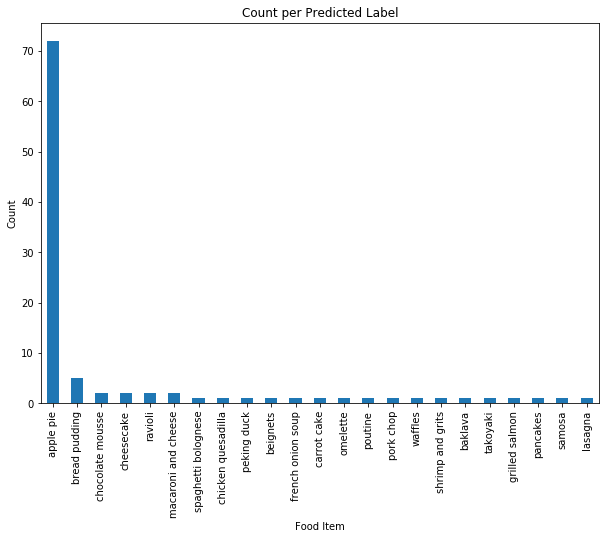

In [31]:
plot_predictions_for_class(results, "apple pie")

Actual: beef carpaccio_305.jpg
Predicted: beef carpaccio


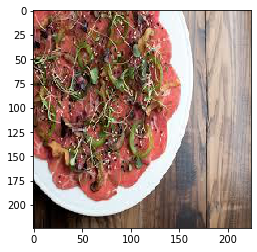

In [36]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[transfer.predict(img).argmax(axis=-1)[0]])